In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

In [8]:
df=pd.read_excel('Online-Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [10]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
df=df[df['CustomerID'].notnull()]
df['CustomerID']=df['CustomerID'].astype(int)

In [12]:
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]

In [13]:
df['TotalPrice']=df['Quantity']*df['UnitPrice']

In [14]:
df_cleaned=df.copy()

In [15]:
df_cleaned.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

In [16]:
customer=df_cleaned.groupby('CustomerID').agg({'InvoiceNo':'nunique','Quantity':'sum','TotalPrice':'sum'}).reset_index()
customer.rename(columns={'InvoiceNo':'NumPurchases','Quantity':'TotalQuantity','TotalPrice':'TotalSpent'},inplace=True)
customer.head()

,CustomerID,NumPurchases,TotalQuantity,TotalSpent
0,12346,1,74215,77183.60
1,12347,7,2458,4310.00
2,12348,4,2341,1797.24
3,12349,1,631,1757.55
4,12350,1,197,334.40


In [17]:
customer=customer[customer['TotalSpent']<customer['TotalSpent'].quantile(0.99)]

In [18]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_data=scaler.fit_transform(customer[['NumPurchases','TotalQuantity','TotalSpent']])

In [19]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca_data=pca.fit_transform(scaled_data)

In [20]:
pca_data

array([[ 1.89872098, -0.45634573],
       [ 0.79672521, -0.60907551],
       [-0.31201477, -0.44526781],
       ...,
       [-0.88508853,  0.11937421],
       [ 1.80055346,  1.73538599],
       [ 0.3598135 , -0.4892581 ]], shape=(4294, 2))

In [21]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
models={'Kmeans':KMeans(n_clusters=4, random_state=42),
        'DBSCAN':DBSCAN(eps=0.5, min_samples=5),
        'Agglomerative':AgglomerativeClustering(n_clusters=4)}

for name,model in models.items():
    y_label=model.fit_predict(pca_data)

In [22]:
from sklearn.metrics import silhouette_score,davies_bouldin_score

for name,model in models.items():
    print(f'\nModel {name}:')
    print(f'Silhouette Score: {silhouette_score(pca_data, y_label)}')
    print(f'Davies Bouldin Score: {davies_bouldin_score(pca_data, y_label)}')


Model Kmeans:
Silhouette Score: 0.640811015561763
Davies Bouldin Score: 0.8520939605334729

Model DBSCAN:
Silhouette Score: 0.640811015561763
Davies Bouldin Score: 0.8520939605334729

Model Agglomerative:
Silhouette Score: 0.640811015561763
Davies Bouldin Score: 0.8520939605334729


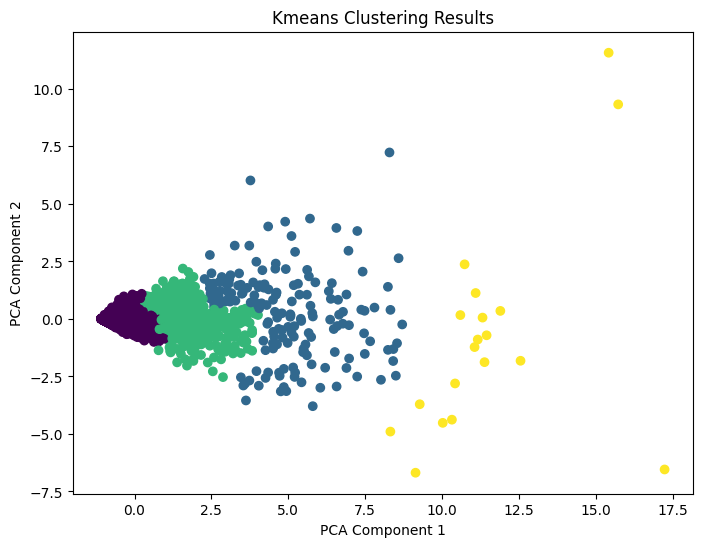

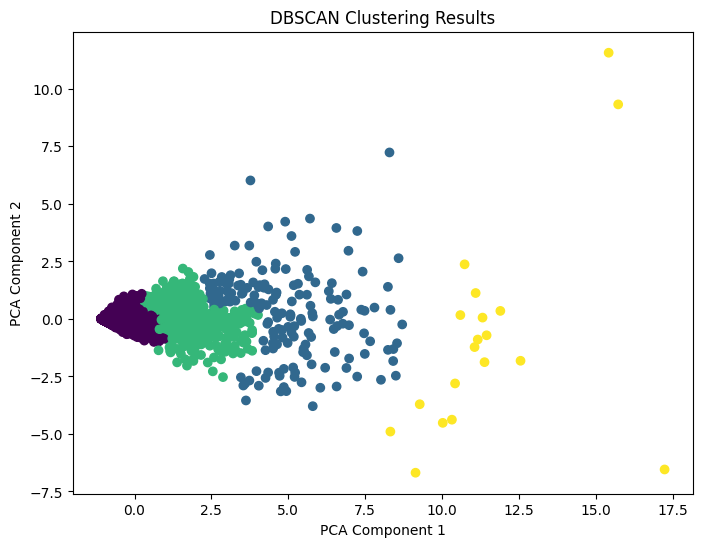

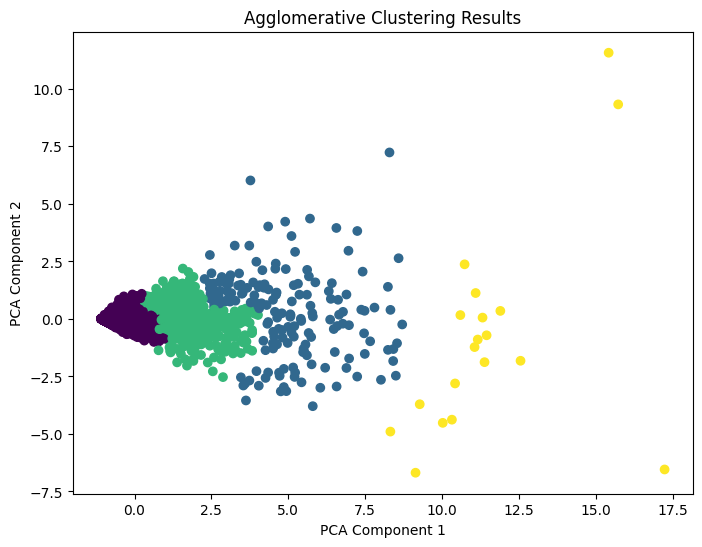

In [23]:
for name,model in models.items():
   plt.figure(figsize=(8,6))
   plt.scatter(pca_data[:,0],pca_data[:,1],c=y_label,cmap='viridis')
   plt.title(f'{name} Clustering Results')
   plt.xlabel('PCA Component 1')
   plt.ylabel('PCA Component 2')
   plt.show()

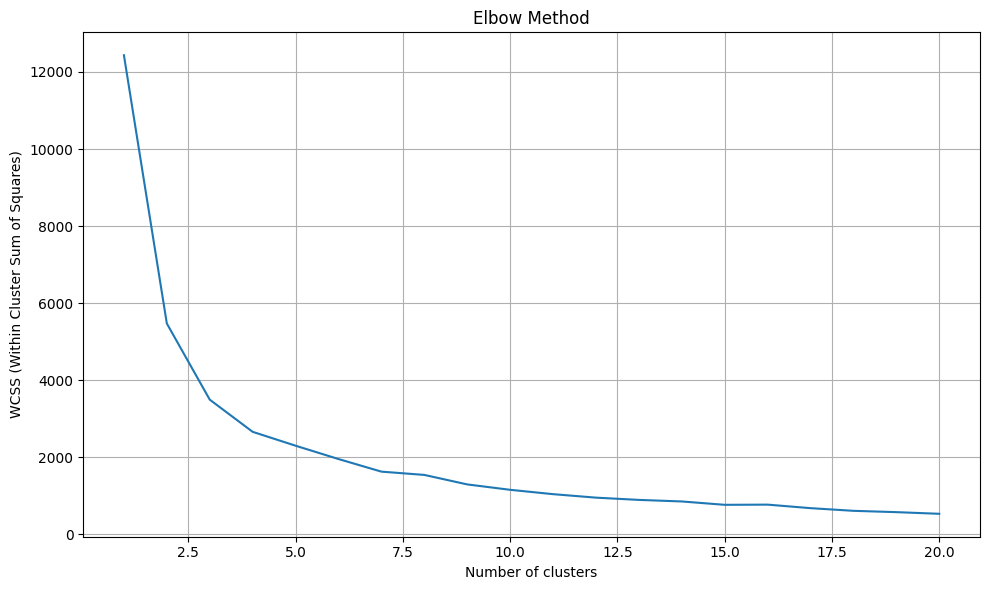

In [24]:
wcss=[]
for i in range(1,21):
    kmeans=KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1,21),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters') 
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
from kneed import KneeLocator
knee=KneeLocator(range(1,21),wcss,curve='convex',direction='decreasing')
print(f'Optimal number of clusters: {knee.knee}')

Optimal number of clusters: 4


In [26]:
best_model=None
best_score=0
for name, model in models.items():
    score=silhouette_score(pca_data, y_label)
    if score>best_score:
        best_score=score
        best_model=model

In [28]:
import joblib
joblib.dump(best_model, 'models.pkl')
joblib.dump(customer, 'customer.pkl')
joblib.dump(pca_data, 'pca_data.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']